In [2]:
#Should include a call to GCP Big query#
#Install gsutil

In [3]:
#Load raw datasets
#questions = context.catalog.load("questions",) 
#lectures = context.catalog.load("lectures",)
#train =  context.catalog.load("train_filter",)

In [4]:
# train = train[train.content_type_id == False]
# #arrange by timestamp


# train = train.sort_values(['timestamp'], ascending=True)

# train.drop(['timestamp','content_type_id'], axis=1,   inplace=True)

# results_c = train[['content_id','answered_correctly']].groupby(['content_id']).agg(['mean'])
# results_c.columns = ["answered_correctly_content"]

# results_u = train[['user_id','answered_correctly']].groupby(['user_id']).agg(['mean', 'sum'])
# results_u.columns = ["answered_correctly_user", 'sum']

In [5]:
#reading in question df
# questions_df = pd.read_csv('data/01_raw/questions.csv',
#                             usecols=[0,1, 3,4],
#                             dtype={'question_id': 'int16',
#                                    'part': 'int8',
#                                    'bundle_id': 'int8',
#                                    'tags': 'str'}
#                                   )

# tag = questions_df["tags"].str.split(" ", n = 10, expand = True) 
# tag.columns = ['tags1','tags2','tags3','tags4','tags5','tags6']

# questions_df =  pd.concat([questions_df,tag],axis=1)
# questions_df['tags1'] = pd.to_numeric(questions_df['tags1'], errors='coerce')
# questions_df['tags2'] = pd.to_numeric(questions_df['tags2'], errors='coerce')
# questions_df['tags3'] = pd.to_numeric(questions_df['tags3'], errors='coerce')
# questions_df['tags4'] = pd.to_numeric(questions_df['tags4'], errors='coerce')
# questions_df['tags5'] = pd.to_numeric(questions_df['tags5'], errors='coerce')
# questions_df['tags6'] = pd.to_numeric(questions_df['tags6'], errors='coerce')

In [6]:
#X = train.iloc[85000000:,:]
#X['prior_question_had_explanation'].fillna(False, inplace=True)
# X = pd.merge(X, results_u, on=['user_id'], how="left")
# X = pd.merge(X, results_c, on=['content_id'], how="left")
# X = pd.merge(X, questions_df, left_on = 'content_id', right_on = 'question_id', how = 'left')

# X=X[X.answered_correctly!= -1 ]
#X=X.sort_values(['user_id'])

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import json

from sklearn.preprocessing import LabelEncoder


parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 1
}

In [2]:
for it,y in enumerate(range(0,78,4)):

    if y == 76:
        end_range = 78
    else:
        end_range=y+4

    print(f"Iteration :{it}")
    list_df = []
    for x in range(y,end_range):
        list_df +=  [pd.read_csv("../data/01_raw/feat_tab0000000000"+f"{x:02d}")]
    train = pd.concat(list_df)


    Y = train[["answered_correctly"]]
    train = train.drop(["answered_correctly"], axis=1)


    lb_make = LabelEncoder()
    train["section"] = lb_make.fit_transform(train["section"])

    train = train[[col for col in train.columns if col not in ['user_id',"timestamp"]]]
    train.fillna(-1,inplace=True)
    train_ds = lgb.Dataset(train, Y,categorical_feature = ['section','part','tags1','tags2','tags3','profile'])


    if it == 0:
        model_cv = lgb.cv(parameters,
                        train_ds,
                        nfold=5,
                        stratified=True,
                        num_boost_round=5000,
                        early_stopping_rounds=100,
                        return_cvbooster=True)

    else:
        model_cv = lgb.cv(parameters,
                        train_ds,
                        nfold=10,
                        stratified=True,
                        num_boost_round=5000,
                        early_stopping_rounds=100,
                        return_cvbooster=True,
                        init_model=lgb.Booster(model_file="model_"+str(it-1)+".bin"))

    with open('auc_mean_'+str(it)+'.json', 'w') as f:
        f.write(json.dumps(model_cv["auc-mean"]))
    with open('auc_stdv_'+str(it)+'.json', 'w') as f:
        f.write(json.dumps(model_cv["auc-stdv"]))
    
    model_cv["cvbooster"].boosters[4].save_model("model_"+str(it)+".bin")

Iteration :0
[LightGBM] [Info] Number of positive: 2313796, number of negative: 2034252
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2053
[LightGBM] [Info] Number of data points in the train set: 4348048, number of used features: 21
[LightGBM] [Info] Number of positive: 2313796, number of negative: 2034252
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2053
[LightGBM] [Info] Number of data points in the train set: 4348048, number of used features: 21
[LightGBM] [Info] Number of positive: 2313796, number of negative: 2034252
[LightGBM] [Warning] Auto-choosing row-wise mu

TypeError: cv() got an unexpected keyword argument 'booster'

In [9]:
# X = X[['answered_correctly_user', 'answered_correctly_content', 'sum','bundle_id','part','prior_question_elapsed_time','prior_question_had_explanation_enc','tags1','tags2','tags3']] 

# X.fillna(0.5,  inplace=True)

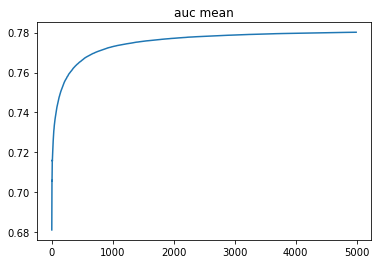

In [3]:
with open('auc_mean_0.json', 'r') as f:
     model_cv_mean = json.loads(f.read())

plt.title("auc mean")
plt.plot(model_cv_mean)
plt.show()

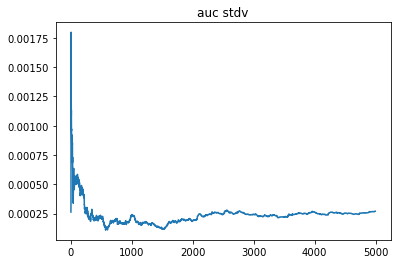

In [4]:
with open('auc_stdv_0.json', 'r') as f:
     model_cv_stdv = json.loads(f.read())

plt.title("auc stdv")
plt.plot(model_cv_stdv)
plt.show()

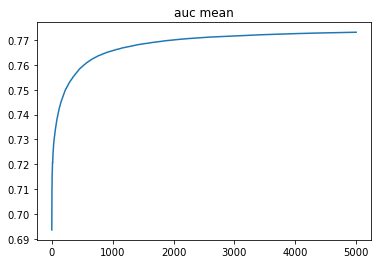

In [13]:
#Plot metric mean value
plt.title("auc mean")
plt.plot(model_cv["auc-mean"])
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

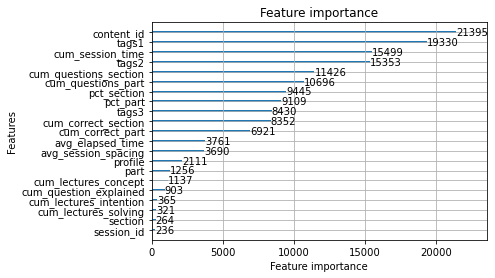

In [5]:
lgb.plot_importance(lgb.Booster(model_file="model_0.bin"))



from  sklearn.model_selection import train_test_split
Xt, Xv, Yt, Yv = train_test_split(X, Y, test_size =0.2, shuffle=False)




lgb_train = lgb.Dataset(Xt, Yt,categorical_feature = ['part','tags1','tags2','tags3'])
lgb_eval = lgb.Dataset(Xv, Yv, reference=lgb_train,categorical_feature = ['part','tags1','tags2','tags3'])

model = lgb.train(
    params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=10,
    num_boost_round=10000,
    early_stopping_rounds=10
)